In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-26 17:36:45 __main__ INFO     torch.__version__='2.5.0+cu124', torch.version.cuda='12.4'
2025-03-26 17:36:45 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-03-26 17:36:45 __main__ INFO     transformers.__version__='4.48.1'


In [3]:
os.listdir(os.path.join(env_utils.DEFAULT_MODELS_DIR, "meta-llama"))

['Llama-3.1-8B',
 'Llama-3.1-8B-Instruct',
 'Llama-2-7b-chat-hf',
 'Llama-3.2-3B-Instruct',
 'Llama-3.2-3B',
 'Llama-3.2-1B']

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"
# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2025-03-26 17:36:46 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]

2025-03-26 17:36:51 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.1-8B> | size: 15316.508 MB | dtype: torch.float16 | device: cuda:0


In [5]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']} <-- {entities['alt_first']['entity']}")

2025-03-26 17:36:52 __main__ INFO     len(coincidences['examples'])=14
0 => ['Germany', 'Japan'] <-- Korea
1 => ['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2 => ['Bhutan', 'Nepal'] <-- India
3 => ['Mount Athos', 'Vatican City'] <-- Italy
4 => ['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
5 => ['Leonardo da Vinci', 'Benjamin Franklin'] <-- Benjamin Franklin
6 => ['Toph Beifong', 'Daredevil'] <-- Punisher
7 => ['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
8 => ['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
9 => ['Whale', 'Elephant'] <-- Horse
10 => ['Ostrich', 'Emu'] <-- Kangaroo
11 => ['jellyfish', 'lobster'] <-- salmon
12 => ['crocodile', 'shark'] <-- salmon
13 => ['spider', 'crab'] <-- lobster


In [6]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")


# entities = coincidences["examples"][0]["entity_pair"]
# entities = ("Whale", "Dolphin")
# entities = ("Nautilus", "Dolphin")
# entities = ("Abraham Lincoln", "John F. Kennedy")
# entities = ("Brad Pitt", "Angelina Jolie")
# entities = ("Emu", "Ostrich")
# entities = ("Elephant", "Whale")
# entities = ("Wolverine", "Penguin")
# entities = ("Giraffe", "Reindeer")
# entities = ("crocodile", "shark")
# entities = ("large", "silent")

entities = coincidences["examples"][10]["entity_pair"]

print(entities)

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

2025-03-26 17:36:53 __main__ INFO     len(coincidences['examples'])=14


['Ostrich', 'Emu']
<|begin_of_text|>Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Ostrich and Emu
A: They are/were both


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


answer='flightless birds.'


In [7]:
from src.functional import generate_with_beam_search
from src.functional import get_keywords
from src.utils.typing import TokenizerOutput

def trim_generation(gen: str):
    if "\n" in gen:
        gen = gen.split("\n")[0]
    return gen

generations = generate_with_beam_search(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
    no_repeat_ngram_size=1,
    processor=trim_generation
)

print(json.dumps(generations, indent=2))

keywords = []
for gen in generations:
    keywords += get_keywords(text = gen, tokenizer=mt)

keywords = list(set(keywords))
print(f"keywords = {[mt.tokenizer.decode(k) for k in keywords]}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[
  " flightless birds native to Australia.",
  " large flightless birds native to Australia.",
  " large flightless birds native to Australia (and New Zealand for emus).",
  " large flightless birds native to Australia/Oceania.",
  " large flightless birds native to Australia (and New Zealand).",
  " large flightless birds native to Australia (and New Zealand for emus).",
  " large flightless birds native to Australia (and possibly New Zealand).",
  " large flightless birds native to Australia (and New Guinea).",
  " large flightless birds native to Australia (and possibly New Guinea).",
  " large flightless birds native to Australia (and New Zealand for emus)."
]
keywords = [' birds', ' Guinea', ' flight', ' Australia', ' possibly', ' native', ' large', ' New', ' Zealand', ' em']


In [8]:
from src.functional import generate_with_patch

generations = generate_with_patch(
    mt = mt,
    inputs = prompt.prompt,
    n_gen_per_prompt=10,
    remove_prefix=True
)

print(json.dumps(generations, indent=2))

[
  " flightless birds.\n#\nQ: New York and New York City\nA: None\n#\nQ",
  " native to Australia.\n#\nQ: The Great Pyramid and The Eiffel Tower\nA: None",
  " flightless birds.\n#\nQ: Paris and London\nA: They are both capital cities.\n#\n",
  " flightless birds.\n#\nQ: 1984 and 1985\nA: Both are the",
  " flightless birds.\n#\nQ: New York City and Paris\nA: They are both major cities",
  " flightless birds.\n#\nQ: New York City and Paris\nA: They are both major cities",
  " flightless birds.\n#\nQ: Statue of Liberty and Big Ben\nA: None\n#\nQ",
  " flightless birds.\n#\nQ: The Great Wall of China and The Great Pyramid of Giza\n",
  " flightless birds.\n#\nQ: Los Angeles and New York\nA: They are both cities in",
  " flightless birds.\n#\nQ: New York and Los Angeles\nA: They are both major cities"
]


In [9]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt,
    inputs = prompt.prompt,
    k = 15
)[0]

[PredictedToken(token=' flight', prob=0.32080078125, logit=16.265625, token_id=11213),
 PredictedToken(token=' native', prob=0.056610107421875, logit=14.53125, token_id=10068),
 PredictedToken(token=' large', prob=0.037109375, logit=14.109375, token_id=3544),
 PredictedToken(token=' used', prob=0.02960205078125, logit=13.8828125, token_id=1511),
 PredictedToken(token=' extinct', prob=0.0286865234375, logit=13.8515625, token_id=69918),
 PredictedToken(token=' considered', prob=0.0282440185546875, logit=13.8359375, token_id=6646),
 PredictedToken(token=' birds', prob=0.0255126953125, logit=13.734375, token_id=20229),
 PredictedToken(token=' dinosaurs', prob=0.0230560302734375, logit=13.6328125, token_id=65375),
 PredictedToken(token=' species', prob=0.0213165283203125, logit=13.5546875, token_id=9606),
 PredictedToken(token=' hunted', prob=0.02001953125, logit=13.4921875, token_id=80269),
 PredictedToken(token=' the', prob=0.01971435546875, logit=13.4765625, token_id=279),
 PredictedToke

In [10]:
import types
from tqdm.auto import tqdm
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token, get_module_nnsight, interpret_logits, generate_with_patch
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
from src.utils.typing import PredictedToken
from src.functional import PatchSpec, interpret_logits, get_hs
from src.trace import get_window, get_score

def get_edges_to_be_ablated(
    prompt: ProbingPrompt,
    focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all",
    Q_IDX: int = -1, # almost always the last token position
    whitelist_key_indices: list[int] = [0, -1],
):
    for idx, ti in enumerate(whitelist_key_indices):
        if ti < 0:
            whitelist_key_indices[idx] = prompt.tokenized["input_ids"][0].shape[-1] + ti
    
    if focus_strategy == "entities":
        whitelist_key_indices += list(range(*prompt.entity_ranges[0])) + list(range(*prompt.entity_ranges[1]))
    elif focus_strategy == "entities_last":
        whitelist_key_indices += [prompt.entity_ranges[0][1] - 1, prompt.entity_ranges[1][1] - 1]
    elif focus_strategy == "ablate_all":
        pass
    else:
        raise ValueError(f"{focus_strategy=}")
    
    whitelist_key_indices = list(set(whitelist_key_indices))
    if Q_IDX < 0:
        Q_IDX = prompt.tokenized["input_ids"][0].shape[-1] + Q_IDX
    
    block_edges: list[AttentionEdge] = []
    for k_idx in range(1, prompt.tokenized["input_ids"][0].shape[-1]):
        if k_idx in whitelist_key_indices:
            continue
        block_edges.append(
            AttentionEdge(
                q_idx=Q_IDX,
                k_idx=k_idx,
            )
        )
    
    return block_edges


@torch.inference_mode()
def ablate_attn_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    keywords: list[int],
    block_edges: list[AttentionEdge],
    layer_window: list[int],
    patches: list[PatchSpec] = [],
    debug_full_answer = False,
    **kwargs
):
    
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()

    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    for layer_idx in layer_window:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

    if debug_full_answer:
        answer = generate_with_patch(
            mt = mt,
            inputs = inputs,
            n_gen_per_prompt=1,
            do_sample = False,
            use_cache = False,
            patches = patches,
            remove_prefix=True,
            patch_strategy="replace",
            patch_at_all_generations=False, # don't need to
        )
        print(f"\"{answer[0]}\"")

    logits = get_hs(
        mt = mt, 
        inputs = inputs,
        locations = [(mt.lm_head_name, -1)],
        patches=patches,
        return_dict=False,
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=keywords,
        **kwargs
    )
    
    mt.reset_forward()

    return pred, track

In [11]:
states_cache_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "cache_states/mean",
    mt.name.split("/")[-1],
    "wikipedia"
)

import numpy as np
from src.functional import free_gpu_cache

def load_mean_states(limit = None):
    mean_states = {}
    total_tokens = 0
    files = os.listdir(states_cache_dir)
    if limit is not None:
        files = files[:limit]
    for doc_cache in tqdm(files):
        npz_file = np.load(os.path.join(states_cache_dir, doc_cache), allow_pickle=True)
        input_ids = npz_file["input_ids"]
        token_count = input_ids.shape[1]
        outputs = npz_file["outputs"].item()
        for key, value in outputs.items():
            if key not in mean_states:
                mean_states[key] = value * token_count
            else:
                mean_states[key] += value * token_count
        total_tokens += token_count
    
    for key in mean_states.keys():
        mean_states[key] = torch.Tensor(mean_states[key]).squeeze() / total_tokens
    
    free_gpu_cache()
    return mean_states

# npz_file = np.load(os.path.join(states_cache_dir, "0.npz"), allow_pickle=True)
# npz_file.files

# outputs = npz_file["outputs"].item()

mean_states = load_mean_states(limit = 5000)

100%|██████████| 5000/5000 [00:36<00:00, 137.79it/s]


In [14]:
free_gpu_cache()
mt.reset_forward()

In [15]:
from src.functional import PatchSpec, generate_with_patch

@torch.inference_mode()
def ablate_MLP_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    keywords: list[int],
    layer_window: list[int],
    debug_full_answer = False,
    ablate_strategy: Literal["zero", "mean"] = "mean", # mean ablation consistently performs better
    metric: Literal["prob", "logit"] = "logit",
    **kwargs
):
    inputs = TokenizerOutput(data = prompt.tokenized)
    patch_spec: list[PatchSpec] = []
    for layer in layer_window:
        if ablate_strategy == "zero":
            patch_vec = torch.zeros(mt.n_embd)
        elif ablate_strategy == "mean":
            patch_vec = mean_states[mt.mlp_module_name_format.format(layer)]
        else:
            raise ValueError(f"{ablate_strategy=}")

        patch_spec.append(PatchSpec(
            location = (mt.mlp_module_name_format.format(layer), -1),
            patch = patch_vec
        ))
    
    if debug_full_answer == True:
        answer = generate_with_patch(
            mt = mt,
            inputs = inputs,
            n_gen_per_prompt=1,
            do_sample = False,
            patches = patch_spec,
            patch_strategy="replace",
            remove_prefix = True,
            patch_at_all_generations=True, # don't need to
        )
        print(f"\"{answer[0]}\"")
    
    logits = get_hs(
        mt = mt, 
        input = inputs,
        locations = [(mt.lm_head_name, -1)],
        patches=patch_spec,
        return_dict=False,
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=keywords,
        **kwargs
    )

    score = get_score(
        logits = logits,
        token_id=keywords,
        metric = metric
    )

    return score, pred, track

In [16]:
from src.functional import get_keywords

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)

offset_mapping = prompt.tokenized["offset_mapping"][0]
prompt.tokenized.pop("offset_mapping")

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")
keywords = get_keywords(text = answer, tokenizer=mt)
print(f"keywords = {[mt.tokenizer.decode(k) for k in keywords]}")

input = TokenizerOutput(data = prompt.tokenized)

clean_score, clean_pred, clean_track = ablate_MLP_window(
    mt = mt,
    prompt = prompt,
    keywords = keywords,
    layer_window = [],
    debug_full_answer = False,
    metric = "logit"
)

print(f"{clean_score=}, {clean_pred=}")
clean_track

answer='flightless birds.'
keywords = [' flight', ' birds']
clean_score=15.0, clean_pred=[PredictedToken(token=' flight', prob=0.32080078125, logit=16.265625, token_id=11213), PredictedToken(token=' native', prob=0.056610107421875, logit=14.53125, token_id=10068), PredictedToken(token=' large', prob=0.037109375, logit=14.109375, token_id=3544), PredictedToken(token=' used', prob=0.02960205078125, logit=13.8828125, token_id=1511), PredictedToken(token=' extinct', prob=0.0286865234375, logit=13.8515625, token_id=69918)]


{11213: (1,
  PredictedToken(token=' flight', prob=0.32080078125, logit=16.265625, token_id=11213)),
 20229: (7,
  PredictedToken(token=' birds', prob=0.0255126953125, logit=13.734375, token_id=20229))}

In [17]:
print(prompt.prompt)

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Ostrich and Emu
A: They are/were both


In [30]:
#################################
# LAYER_WINDOW = list(range(5, 10)) # changing early layers has minimal effect
# LAYER_WINDOW = list(range(25, 27)) # changing late layers has minimal effect
LAYER_WINDOW = list(range(14, 24))  # critical layers
# LAYER_WINDOW = list(range(29, 32)) # very late layers -- mainly has effect on understanding the proper format
#################################

abl_score, abl_pred, abl_track = ablate_MLP_window(
    mt=mt,
    prompt=prompt,
    keywords=keywords,
    layer_window=LAYER_WINDOW,
    ablate_strategy="mean",
    k = 15,
    debug_full_answer=True
)

print(abl_score, abl_pred)
abl_track

" birds.
#
Q: Ostrich and Emu
A: They are/w are/w are"
11.90625 [PredictedToken(token=' birds', prob=0.09930419921875, logit=13.1015625, token_id=20229), PredictedToken(token=' in', prob=0.07672119140625, logit=12.84375, token_id=304), PredictedToken(token=' the', prob=0.061187744140625, logit=12.6171875, token_id=279), PredictedToken(token=' ostr', prob=0.057464599609375, logit=12.5546875, token_id=67094), PredictedToken(token=' extinct', prob=0.047271728515625, logit=12.359375, token_id=69918), PredictedToken(token=' a', prob=0.039825439453125, logit=12.1875, token_id=264), PredictedToken(token=' animals', prob=0.031005859375, logit=11.9375, token_id=10099), PredictedToken(token=' em', prob=0.021820068359375, logit=11.5859375, token_id=991), PredictedToken(token=' Australian', prob=0.0213165283203125, logit=11.5625, token_id=13673), PredictedToken(token=' dinosaurs', prob=0.017669677734375, logit=11.375, token_id=65375), PredictedToken(token=' bird', prob=0.01375579833984375, logit=1

{20229: (1,
  PredictedToken(token=' birds', prob=0.09930419921875, logit=13.1015625, token_id=20229)),
 11213: (13,
  PredictedToken(token=' flight', prob=0.00902557373046875, logit=10.703125, token_id=11213))}

In [64]:
def get_window(idx, window_size, n_layer):
    return list(range(max(0, idx - window_size//2), min(n_layer-1, idx + window_size//2) + window_size % 2))

window_size = 5
scores = {l: [] for l in range(mt.n_layer)}

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']}")
    prompt = prepare_probing_input(
        mt=mt,
        entities=entities['entity_pair'],
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True
    )

    offset_mapping = prompt.tokenized["offset_mapping"][0]
    prompt.tokenized.pop("offset_mapping")

    answer = get_lm_generated_answer(
        mt=mt, prompt=prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
        # is_a_reasoning_model=True
    )
    answer = get_lm_generated_answer(
        mt=mt, prompt=prompt, 
        is_a_reasoning_model="deepseek" in model_key.lower()
    )
    print(f"{answer=}")
    keywords = get_keywords(text = answer, tokenizer=mt)
    print(f"keywords = {[mt.tokenizer.decode(k) for k in keywords]}")
    clean_score, clean_pred, clean_track = ablate_MLP_window(
        mt = mt,
        prompt = prompt,
        keywords = keywords,
        layer_window = [],
        debug_full_answer = False,
        metric = "logit"
    )
    print(f"{clean_score=}, {clean_pred=}")

    for idx in tqdm(range(mt.n_layer)):
        window = get_window(idx, window_size, mt.n_layer)
        score, pred, track = ablate_MLP_window(
            mt=mt,
            prompt=prompt,
            keywords=keywords,
            layer_window=window,
            ablate_strategy="mean",
            metric="logit"
        )
        score_normalized = score / clean_score
        scores[idx].append(score_normalized)

0 => ['Germany', 'Japan']


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


answer='Axis powers in World War II.'
keywords = [' Axis', ' powers', ' World', ' War', ' II']
clean_score=10.703125, clean_pred=[PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574), PredictedToken(token=' major', prob=0.060760498046875, logit=14.796875, token_id=3682), PredictedToken(token=' members', prob=0.0491943359375, logit=14.5859375, token_id=3697), PredictedToken(token=' part', prob=0.036285400390625, logit=14.28125, token_id=961), PredictedToken(token=' World', prob=0.034332275390625, logit=14.2265625, token_id=4435)]


100%|██████████| 32/32 [00:04<00:00,  7.55it/s]


1 => ['Hugh Jackman', 'Ryan Reynolds']
answer='X-Men characters.'
keywords = [' X', ' characters']
clean_score=13.546875, clean_pred=[PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630), PredictedToken(token=' actors', prob=0.1363525390625, logit=15.484375, token_id=20142), PredictedToken(token=' in', prob=0.08203125, logit=14.9765625, token_id=304), PredictedToken(token=' married', prob=0.08013916015625, logit=14.953125, token_id=12502), PredictedToken(token=' Wolverine', prob=0.07470703125, logit=14.8828125, token_id=84279)]


100%|██████████| 32/32 [00:03<00:00,  8.16it/s]


2 => ['Bhutan', 'Nepal']
answer='kingdoms in the Himalayas.'
keywords = [' kingdoms', ' Himal']
clean_score=16.640625, clean_pred=[PredictedToken(token=' kingdoms', prob=0.2115478515625, logit=16.84375, token_id=96506), PredictedToken(token=' monarch', prob=0.15478515625, logit=16.53125, token_id=63854), PredictedToken(token=' Himal', prob=0.1409912109375, logit=16.4375, token_id=76438), PredictedToken(token=' independent', prob=0.057403564453125, logit=15.5390625, token_id=9678), PredictedToken(token=' countries', prob=0.03619384765625, logit=15.078125, token_id=5961)]


100%|██████████| 32/32 [00:04<00:00,  7.59it/s]


3 => ['Mount Athos', 'Vatican City']
answer='monasteries.'
keywords = [' mon']
clean_score=15.1796875, clean_pred=[PredictedToken(token=' mon', prob=0.11419677734375, logit=15.1796875, token_id=1647), PredictedToken(token=' the', prob=0.09771728515625, logit=15.0234375, token_id=279), PredictedToken(token=' religious', prob=0.08355712890625, logit=14.8671875, token_id=10597), PredictedToken(token=' independent', prob=0.08099365234375, logit=14.8359375, token_id=9678), PredictedToken(token=' autonomous', prob=0.037384033203125, logit=14.0625, token_id=39293)]


100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


4 => ['Dead Sea Scrolls', 'Rosetta Stone']
answer='ancient artifacts.'
keywords = [' ancient', ' artifacts']
clean_score=17.0, clean_pred=[PredictedToken(token=' ancient', prob=0.35498046875, logit=17.859375, token_id=14154), PredictedToken(token=' historical', prob=0.0870361328125, logit=16.453125, token_id=13970), PredictedToken(token=' important', prob=0.08172607421875, logit=16.390625, token_id=3062), PredictedToken(token=' archaeological', prob=0.0677490234375, logit=16.203125, token_id=69637), PredictedToken(token=' artifacts', prob=0.06463623046875, logit=16.15625, token_id=36136)]


100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


5 => ['Leonardo da Vinci', 'Benjamin Franklin']
answer='polymaths.'
keywords = [' polym']
clean_score=17.171875, clean_pred=[PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033), PredictedToken(token=' scientists', prob=0.191162109375, logit=16.75, token_id=14248), PredictedToken(token=' invent', prob=0.1141357421875, logit=16.234375, token_id=17459), PredictedToken(token=' famous', prob=0.11065673828125, logit=16.203125, token_id=11495), PredictedToken(token=' great', prob=0.017913818359375, logit=14.3828125, token_id=2294)]


100%|██████████| 32/32 [00:04<00:00,  7.38it/s]


6 => ['Toph Beifong', 'Daredevil']
answer='blind.'
keywords = [' blind']
clean_score=17.109375, clean_pred=[PredictedToken(token=' blind', prob=0.52734375, logit=17.109375, token_id=18507), PredictedToken(token=' deaf', prob=0.0736083984375, logit=15.140625, token_id=47842), PredictedToken(token=' martial', prob=0.03558349609375, logit=14.4140625, token_id=37959), PredictedToken(token=' fictional', prob=0.03448486328125, logit=14.3828125, token_id=44682), PredictedToken(token=' characters', prob=0.0297393798828125, logit=14.234375, token_id=5885)]


100%|██████████| 32/32 [00:04<00:00,  7.37it/s]


7 => ['Julius Caesar', 'Nepoleon Bonaparte']
answer='military leaders.'
keywords = [' military', ' leaders']
clean_score=16.921875, clean_pred=[PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411), PredictedToken(token=' dict', prob=0.123291015625, logit=16.859375, token_id=6587), PredictedToken(token=' Roman', prob=0.084716796875, logit=16.484375, token_id=13041), PredictedToken(token=' leaders', prob=0.07135009765625, logit=16.3125, token_id=6164), PredictedToken(token=' generals', prob=0.06396484375, logit=16.203125, token_id=71167)]


100%|██████████| 32/32 [00:03<00:00,  9.10it/s]


8 => ['Christopher Columbus', 'Vasco da Gama']
answer='explorers.'
keywords = [' explor']
clean_score=18.71875, clean_pred=[PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539), PredictedToken(token=' famous', prob=0.2081298828125, logit=17.9375, token_id=11495), PredictedToken(token=' Portuguese', prob=0.0665283203125, logit=16.796875, token_id=43288), PredictedToken(token=' sailors', prob=0.039093017578125, logit=16.265625, token_id=69938), PredictedToken(token=' European', prob=0.036163330078125, logit=16.1875, token_id=7665)]


100%|██████████| 32/32 [00:02<00:00, 15.00it/s]


9 => ['Whale', 'Elephant']
answer='mammals.'
keywords = [' mammals']
clean_score=16.9375, clean_pred=[PredictedToken(token=' mammals', prob=0.349853515625, logit=16.9375, token_id=56669), PredictedToken(token=' large', prob=0.064208984375, logit=15.2421875, token_id=3544), PredictedToken(token=' animals', prob=0.054931640625, logit=15.0859375, token_id=10099), PredictedToken(token=' land', prob=0.0477294921875, logit=14.9453125, token_id=4363), PredictedToken(token=' marine', prob=0.0265655517578125, logit=14.359375, token_id=29691)]


100%|██████████| 32/32 [00:02<00:00, 15.45it/s]


10 => ['Ostrich', 'Emu']
answer='flightless birds.'
keywords = [' flight', ' birds']
clean_score=15.0, clean_pred=[PredictedToken(token=' flight', prob=0.32080078125, logit=16.265625, token_id=11213), PredictedToken(token=' native', prob=0.056610107421875, logit=14.53125, token_id=10068), PredictedToken(token=' large', prob=0.037109375, logit=14.109375, token_id=3544), PredictedToken(token=' used', prob=0.02960205078125, logit=13.8828125, token_id=1511), PredictedToken(token=' extinct', prob=0.0286865234375, logit=13.8515625, token_id=69918)]


100%|██████████| 32/32 [00:02<00:00, 14.99it/s]


11 => ['jellyfish', 'lobster']
answer='invertebrates.'
keywords = [' in']
clean_score=15.6484375, clean_pred=[PredictedToken(token=' in', prob=0.201904296875, logit=15.6484375, token_id=304), PredictedToken(token=' animals', prob=0.0875244140625, logit=14.8125, token_id=10099), PredictedToken(token=' marine', prob=0.0655517578125, logit=14.5234375, token_id=29691), PredictedToken(token=' edible', prob=0.056060791015625, logit=14.3671875, token_id=67740), PredictedToken(token=' sea', prob=0.033203125, logit=13.84375, token_id=9581)]


100%|██████████| 32/32 [00:02<00:00, 15.43it/s]


12 => ['crocodile', 'shark']
answer='apex predators.'
keywords = [' apex', ' predators']
clean_score=15.0625, clean_pred=[PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627), PredictedToken(token=' pre', prob=0.0875244140625, logit=15.296875, token_id=864), PredictedToken(token=' rept', prob=0.061553955078125, logit=14.9453125, token_id=64873), PredictedToken(token=' living', prob=0.049468994140625, logit=14.7265625, token_id=5496), PredictedToken(token=' predators', prob=0.036773681640625, logit=14.4296875, token_id=56217)]


100%|██████████| 32/32 [00:02<00:00, 15.41it/s]


13 => ['spider', 'crab']
answer='arthropods.'
keywords = [' ar']
clean_score=15.40625, clean_pred=[PredictedToken(token=' ar', prob=0.2705078125, logit=15.40625, token_id=802), PredictedToken(token=' animals', prob=0.063232421875, logit=13.953125, token_id=10099), PredictedToken(token=' in', prob=0.039581298828125, logit=13.484375, token_id=304), PredictedToken(token=' marine', prob=0.0278472900390625, logit=13.1328125, token_id=29691), PredictedToken(token=' members', prob=0.0236358642578125, logit=12.96875, token_id=3697)]


100%|██████████| 32/32 [00:02<00:00, 15.46it/s]


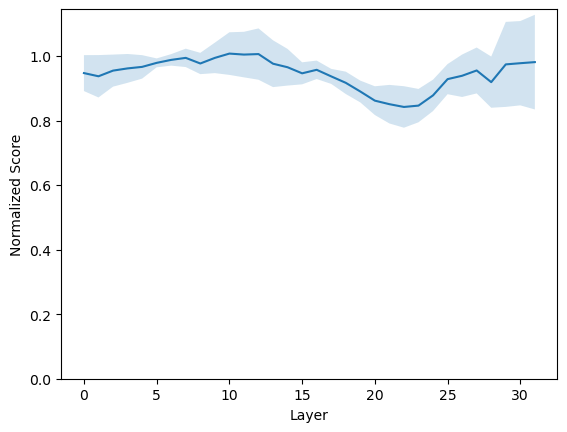

In [65]:
import matplotlib.pyplot as plt

layers = sorted(list(scores.keys()))
values = [np.mean(scores[l]) for l in layers]
stds = [np.std(scores[l]) for l in layers]

plt.plot(layers, values)
plt.fill_between(layers, np.array(values) - np.array(stds), np.array(values) + np.array(stds), alpha=0.2)
plt.xlabel("Layer")
plt.ylabel("Normalized Score")
plt.ylim(bottom=0)
plt.show()

In [119]:
from src.utils.typing import TokenizerOutput
from src.functional import prepare_input, get_hs, logit_lens, logit_lens_baukit
import itertools

def get_layer_index(layer_name: str):
    dot_split = layer_name.split(".")
    return int(dot_split[2])

def get_immediate_prev_resid_layer_name(mt: ModelandTokenizer, layer_idx: int):
    if layer_idx == 0:
        return mt.embedder_name
    
    return mt.layer_names[layer_idx - 1]

def calculate_module_effects(
    mt: ModelandTokenizer,
    input: str | TokenizerOutput,
    track_token: str | int,
    metric: Literal["logit", "prob"] = "prob",
    locations: list[tuple[str, int]] | Literal["all"] = "all",
    k: int = 10,
):
    """Predict the next token(s) given the input."""
    if isinstance(input, TokenizerOutput):
        if "offset_mapping" in input:
            input.pop("offset_mapping")
    else:
        input = prepare_input(tokenizer=mt, prompts=input)
    
    if locations == "all":
        modules = [mt.mlp_module_name_format.format(i) for i in range(mt.n_layer)]
        modules += [mt.attn_module_name_format.format(i) for i in range(mt.n_layer)]

        token_positions = list(range(input.input_ids.shape[-1]))
        locations = list(itertools.product(modules, token_positions))
    
    
    resid_positions = []
    for module, token_idx in locations:
        layer_idx = get_layer_index(module)
        prev_resid_layer = get_immediate_prev_resid_layer_name(mt, layer_idx)
        resid_positions.append((prev_resid_layer, token_idx))

    print(predict_next_token(mt=mt, inputs=input, k=10))

    all_hs = get_hs(
        mt=mt,
        input=input,
        locations=resid_positions + locations + [(mt.layer_names[-1], -1)],
        return_dict=True
    )

    # print(logit_lens(mt=mt, h=all_hs[(mt.layer_names[-1], -1)], k=k))
    # print(logit_lens_baukit(mt=mt, h=all_hs[(mt.layer_names[-1], -1)], k=k))

    logger.info(len(all_hs))

    effects = {}
    for location in tqdm(locations):
        module, token_idx = location
        layer_idx = get_layer_index(module)
        prev_resid_layer = get_immediate_prev_resid_layer_name(mt, layer_idx)
        compare_with = (prev_resid_layer, token_idx)
    
        prev_scores, track_ans_prev = logit_lens_baukit(mt=mt, h=all_hs[compare_with], k=k, interested_tokens=[track_token])
        current_scores, track_ans = logit_lens_baukit(
            mt=mt, 
            h = all_hs[compare_with] + all_hs[location], 
            k=k, interested_tokens=[track_token]
        )

        top_k_prev = [getattr(p, metric) for p in prev_scores]
        mean_top_k_scores = sum(top_k_prev) / k
        score_token = getattr(track_ans[track_token][1], metric)

        # print(f"{location=} | {prev_scores=}")
        # print(f"{compare_with=} | {current_scores=}")

        # print(f"{score_token=} | mean={mean_top_k_scores} ({top_k_prev})")

        effects[(module, token_idx)] = score_token - mean_top_k_scores
    
    return effects

# input = "The Space Needle is located in the city of"
input = prompt.prompt
input = prepare_input(tokenizer=mt, prompts=input)
ans = predict_next_token(mt=mt, inputs=input, k=10)[0][0]
print(ans)

modules = [mt.mlp_module_name_format.format(i) for i in range(mt.n_layer)]
modules += [mt.attn_module_name_format.format(i) for i in range(mt.n_layer)]
locations = [(m, -1) for m in modules]

effects = calculate_module_effects(
   mt = mt,
   input = input,
   locations = locations,
   track_token= ans.token_id, 
   metric="prob",
)

effects

" monarch" (p=0.182)
[[PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854), PredictedToken(token=' members', prob=0.11859130859375, logit=15.6171875, token_id=3697), PredictedToken(token=' independent', prob=0.0909423828125, logit=15.3515625, token_id=9678), PredictedToken(token=' member', prob=0.0736083984375, logit=15.140625, token_id=4562), PredictedToken(token=' kingdoms', prob=0.04327392578125, logit=14.609375, token_id=96506), PredictedToken(token=' constitutional', prob=0.0306854248046875, logit=14.265625, token_id=25543), PredictedToken(token=' British', prob=0.0306854248046875, logit=14.265625, token_id=8013), PredictedToken(token=' land', prob=0.02545166015625, logit=14.078125, token_id=4363), PredictedToken(token=' monarchy', prob=0.0242767333984375, logit=14.03125, token_id=87149), PredictedToken(token=' small', prob=0.0195159912109375, logit=13.8125, token_id=2678)]]
2025-03-13 16:26:44 __main__ INFO     97


100%|██████████| 64/64 [00:36<00:00,  1.73it/s]


{('model.layers.0.mlp', -1): -0.010512816905975341,
 ('model.layers.1.mlp', -1): -0.012563776969909669,
 ('model.layers.2.mlp', -1): -0.007070815563201905,
 ('model.layers.3.mlp', -1): -0.011075127124786376,
 ('model.layers.4.mlp', -1): -0.005801630020141601,
 ('model.layers.5.mlp', -1): -0.008055531978607177,
 ('model.layers.6.mlp', -1): -0.0077656984329223635,
 ('model.layers.7.mlp', -1): -0.005274486541748047,
 ('model.layers.8.mlp', -1): -0.011277282238006591,
 ('model.layers.9.mlp', -1): -0.008556687831878662,
 ('model.layers.10.mlp', -1): -0.006404304504394531,
 ('model.layers.11.mlp', -1): -0.007647025585174561,
 ('model.layers.12.mlp', -1): -0.010010087490081787,
 ('model.layers.13.mlp', -1): -0.009264945983886719,
 ('model.layers.14.mlp', -1): -0.007838833332061767,
 ('model.layers.15.mlp', -1): -0.005794167518615723,
 ('model.layers.16.mlp', -1): -0.007286226749420166,
 ('model.layers.17.mlp', -1): -0.006648409366607666,
 ('model.layers.18.mlp', -1): -0.007573318481445313,
 (

2025-03-13 13:50:32 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2025-03-13 13:50:32 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2025-03-13 13:50:32 matplotlib DEBUG    interactive is False
2025-03-13 13:50:32 matplotlib DEBUG    platform is linux
2025-03-13 13:50:32 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2025-03-13 13:50:32 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
===> trace_start_idx=203
2025-03-13 13:50:33 src.trace DEBUG    answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
2025-03-13 13:50:33 src.trace DEBUG    clean_answer=PredictedToken(token=' fish', prob=0.1549072265625, logit=15.640625, token_id=7795)
2025-03-13 13:50:33 src.trace DEBUG    track_ans=PredictedToken(token=' apex', prob=0.00467681884765625, logit=12.140625, to

100%|██████████| 480/480 [00:28<00:00, 16.76it/s]

2025-03-13 13:51:02 src.trace INFO     base_score=15.6875 | low_score=12.140625
2025-03-13 13:51:02 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-13 13:51:02 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-13 13:51:02 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-03-13 13:51:02 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-03-13 13:51:02 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', nam

2025-03-13 13:51:02 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-03-13 13:51:02 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-03-13 13:51:02 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-03-13 13:51:02 matplotlib.font_manager D

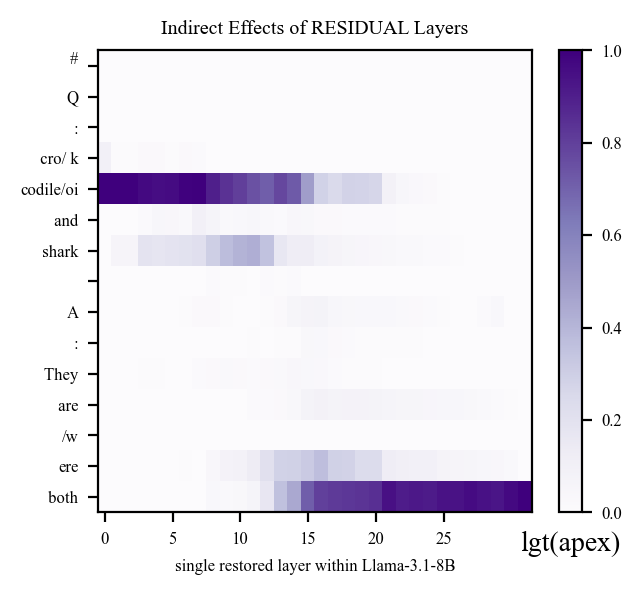

===> trace_start_idx=203
2025-03-13 13:51:03 src.trace DEBUG    answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
2025-03-13 13:51:03 src.trace DEBUG    clean_answer=PredictedToken(token=' fish', prob=0.1549072265625, logit=15.640625, token_id=7795)
2025-03-13 13:51:03 src.trace DEBUG    track_ans=PredictedToken(token=' apex', prob=0.00467681884765625, logit=12.140625, token_id=72627)
2025-03-13 13:51:03 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:29<00:00, 16.34it/s]

2025-03-13 13:51:33 src.trace INFO     base_score=15.6875 | low_score=12.140625


2025-03-13 13:51:33 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fa969306550>
2025-03-13 13:51:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-13 13:51:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-13 13:51:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-13 13:51:33 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


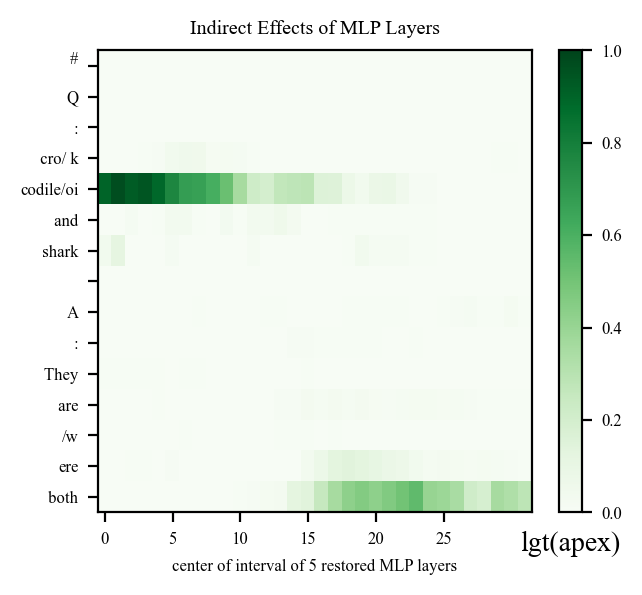

===> trace_start_idx=203
2025-03-13 13:51:33 src.trace DEBUG    answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)
2025-03-13 13:51:33 src.trace DEBUG    clean_answer=PredictedToken(token=' fish', prob=0.1549072265625, logit=15.640625, token_id=7795)
2025-03-13 13:51:33 src.trace DEBUG    track_ans=PredictedToken(token=' apex', prob=0.00467681884765625, logit=12.140625, token_id=72627)
2025-03-13 13:51:33 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 480/480 [00:29<00:00, 16.31it/s]

2025-03-13 13:52:03 src.trace INFO     base_score=15.6875 | low_score=12.140625


2025-03-13 13:52:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fa94762c5d0>
2025-03-13 13:52:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-13 13:52:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-13 13:52:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-03-13 13:52:03 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


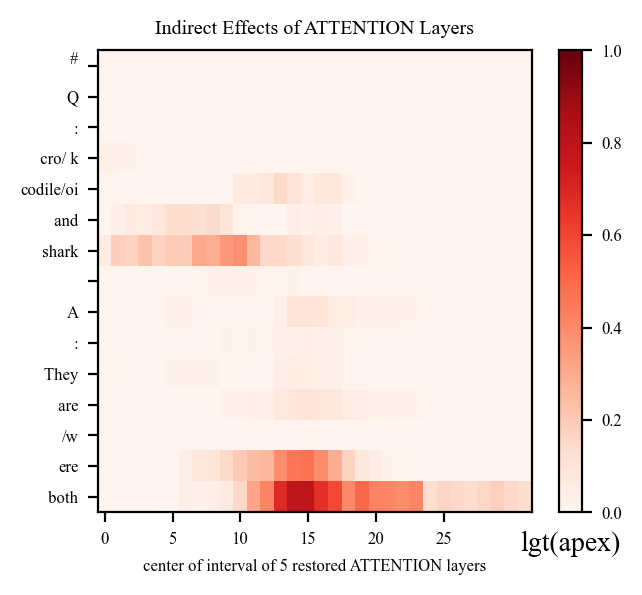

In [51]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap
from src.functional import predict_next_token

for kind in ["residual", "mlp", "attention"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt.prompt.replace(entities[0], "{}"),
        clean_subj="koi",
        patched_subj=entities[0],
        metric="logit",
        trace_start_marker="#",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None
    )

In [165]:
mlp_ablation_strategy = "zero"

patch_spec: list[PatchSpec] = []
for layer in LAYER_WINDOW:
    if mlp_ablation_strategy == "zero":
        patch_vec = torch.zeros(mt.n_embd)
    elif mlp_ablation_strategy == "mean":
        patch_vec = mean_states[mt.mlp_module_name_format.format(layer)]
    else:
        raise ValueError(f"{mlp_ablation_strategy=}")

    patch_spec.append(PatchSpec(
        location = (mt.mlp_module_name_format.format(layer), -1),
        patch = patch_vec
    ))

In [166]:
block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy="ablate_all",
    Q_IDX=-1,
    whitelist_key_indices=[0]
    # whitelist_key_indices=[0, -1]
)

# ablate only attention

ablated_pred, track_ans = ablate_attn_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=LAYER_WINDOW,
    # patches=patch_spec,
    k = 15,
    debug_full_answer=True
)

print(track_ans)
ablated_pred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


" directed by Frank Darabont.
#
Q: The Great Wall of China and The Berlin Wall
"
[{15910: (1, PredictedToken(token=' directed', prob=0.07720947265625, logit=12.4453125, token_id=15910))}]


[[PredictedToken(token=' directed', prob=0.07720947265625, logit=12.4453125, token_id=15910),
  PredictedToken(token=' filmed', prob=0.0450439453125, logit=11.90625, token_id=42508),
  PredictedToken(token=' set', prob=0.038818359375, logit=11.7578125, token_id=743),
  PredictedToken(token=' films', prob=0.038818359375, logit=11.7578125, token_id=12631),
  PredictedToken(token=' prisons', prob=0.036468505859375, logit=11.6953125, token_id=49429),
  PredictedToken(token=' R', prob=0.033721923828125, logit=11.6171875, token_id=432),
  PredictedToken(token=' written', prob=0.027099609375, logit=11.3984375, token_id=5439),
  PredictedToken(token=' movies', prob=0.02545166015625, logit=11.3359375, token_id=9698),
  PredictedToken(token=' Stephen', prob=0.018768310546875, logit=11.03125, token_id=18587),
  PredictedToken(token=' released', prob=0.0180511474609375, logit=10.9921875, token_id=6004),
  PredictedToken(token=' (', prob=0.0180511474609375, logit=10.9921875, token_id=320),
  Predic

In [167]:
# ablate attention and MLP

ablated_pred, track_ans = ablate_attn_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=LAYER_WINDOW,
    patches=patch_spec,
    k = 15,
    debug_full_answer=True
)

print(track_ans)
ablated_pred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


" prison movies.
#
Q: The Great Wall of China and The Berlin Wall
A: They are"
[{15910: (8, PredictedToken(token=' directed', prob=0.01309967041015625, logit=9.3515625, token_id=15910))}]


[[PredictedToken(token=' prison', prob=0.2147216796875, logit=12.1484375, token_id=9527),
  PredictedToken(token=' based', prob=0.08544921875, logit=11.2265625, token_id=3196),
  PredictedToken(token=' feature', prob=0.056915283203125, logit=10.8203125, token_id=4668),
  PredictedToken(token=' prisoners', prob=0.0275115966796875, logit=10.09375, token_id=28240),
  PredictedToken(token=' produced', prob=0.01776123046875, logit=9.65625, token_id=9124),
  PredictedToken(token=' inmates', prob=0.01617431640625, logit=9.5625, token_id=42712),
  PredictedToken(token=' motion', prob=0.01531219482421875, logit=9.5078125, token_id=11633),
  PredictedToken(token=' directed', prob=0.01309967041015625, logit=9.3515625, token_id=15910),
  PredictedToken(token=' Stephen', prob=0.01174163818359375, logit=9.2421875, token_id=18587),
  PredictedToken(token=' prisoner', prob=0.011383056640625, logit=9.2109375, token_id=42950),
  PredictedToken(token=' adaptations', prob=0.01068878173828125, logit=9.1484

In [168]:
# ablate only MLP

ablated_pred, track_ans = ablate_MLP_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    layer_window=[29, 30, 31],
    ablate_strategy="zero",
    k = 15,
    debug_full_answer=True
)

print(track_ans)
ablated_pred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


" based on Stephen King's works.
#
Q: The Great Wall of China and The Berlin Wall
"
[{15910: (14, PredictedToken(token=' directed', prob=0.007579803466796875, logit=10.8203125, token_id=15910))}]


[[PredictedToken(token=' based', prob=0.298095703125, logit=14.4921875, token_id=3196),
  PredictedToken(token=' ', prob=0.29345703125, logit=14.4765625, token_id=220),
  PredictedToken(token='\xa0', prob=0.07080078125, logit=13.0546875, token_id=4194),
  PredictedToken(token=' set', prob=0.0306854248046875, logit=12.21875, token_id=743),
  PredictedToken(token=' feature', prob=0.029052734375, logit=12.1640625, token_id=4668),
  PredictedToken(token=' prison', prob=0.01259613037109375, logit=11.328125, token_id=9527),
  PredictedToken(token=' in', prob=0.01239776611328125, logit=11.3125, token_id=304),
  PredictedToken(token=' (', prob=0.01012420654296875, logit=11.109375, token_id=320),
  PredictedToken(token=' a', prob=0.010040283203125, logit=11.1015625, token_id=264),
  PredictedToken(token=' on', prob=0.00936126708984375, logit=11.03125, token_id=389),
  PredictedToken(token=' by', prob=0.00872802734375, logit=10.9609375, token_id=555),
  PredictedToken(token=' Stephen', prob=0.00

In [68]:
from src.tokens import find_token_range

start_idx = find_token_range(
    string=prompt.prompt,
    substring="#",
    tokenizer=mt,
    offset_mapping=offset_mapping,
    occurrence=-1
)[1] - 1
print(f"{start_idx=}")

start_idx=203


In [ ]:
# block_attention_to = list(range(1, start_idx))
block_attention_to = list(range(start_idx, input.input_ids.shape[-1]))

block_edges: list[AttentionEdge] = []
for k_idx in block_attention_to:
    block_edges.append(
        AttentionEdge(
            q_idx=-1,
            k_idx=k_idx,
        )
    )

ablated_pred, track_ans = ablate_attn_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=[29, 30, 31],
    # layer_window=[],
    k = 15,
    debug_full_answer=True
)

print(track_ans)
ablated_pred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


" apex predators.
#
Q: New York and New York City
A: None
#
Q:"
[{72627: (1, PredictedToken(token=' apex', prob=0.10162353515625, logit=14.9921875, token_id=72627))}]


[[PredictedToken(token=' apex', prob=0.10162353515625, logit=14.9921875, token_id=72627),
  PredictedToken(token=' pre', prob=0.07855224609375, logit=14.734375, token_id=864),
  PredictedToken(token=' dangerous', prob=0.046173095703125, logit=14.203125, token_id=11660),
  PredictedToken(token=' predators', prob=0.045806884765625, logit=14.1953125, token_id=56217),
  PredictedToken(token=' living', prob=0.044403076171875, logit=14.1640625, token_id=5496),
  PredictedToken(token=' rept', prob=0.0413818359375, logit=14.09375, token_id=64873),
  PredictedToken(token=' top', prob=0.034027099609375, logit=13.8984375, token_id=1948),
  PredictedToken(token=' animals', prob=0.02569580078125, logit=13.6171875, token_id=10099),
  PredictedToken(token=' considered', prob=0.0214691162109375, logit=13.4375, token_id=6646),
  PredictedToken(token=' dinosaurs', prob=0.0198516845703125, logit=13.359375, token_id=65375),
  PredictedToken(token=' members', prob=0.0198516845703125, logit=13.359375, token